In [137]:
%pip install kmodes --quiet
%pip install gower --quiet
%pip install optuna --quiet
%pip install gower validclust --quiet
%pip install scikit-learn-extra --quiet
%pip install plotly --quiet


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [138]:
import warnings
warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning,
    message=".*datetime.datetime.utcnow.*"
)

In [139]:
import numpy as np
from kmodes.kprototypes import KPrototypes
import pandas as pd
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
import shap
from sklearn.tree import DecisionTreeClassifier, export_text
import pandas as pd
import gower
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid
import optuna
from sklearn.metrics import silhouette_score, davies_bouldin_score
from validclust import dunn
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy.spatial.distance import pdist



In [140]:
# Load Data
province_df = pd.read_csv('../data/tropical_cyclones_records_f.csv')
province_df.head()

,region_,person_sum,dead_sum,injured_ill_sum,missing_sum,totally_sum,partially_sum,cost_sum,has_food_sum,has_cash_sum,has_hygiene_health_sum,has_sleeping_essentials_sum,has_shelter_support_sum,num_typhoons,recurrence_rate,cost_per_family
0,CAR,665436.0,2.0,115.0,0.0,58.0,888.0,29463089.14,61,46,8,4,4,29,5.80,154.257011
1,13,1651.0,0.0,0.0,0.0,4.0,6.0,280324.00,0,0,0,0,0,2,2.00,737.694737
2,CARAGA,187974.0,0.0,0.0,0.0,2872.0,9370.0,20049094.82,1,0,0,0,0,7,1.40,448.877081
3,CARAGA,221391.0,0.0,0.0,0.0,167.0,707.0,6707484.86,3,0,0,0,0,5,1.25,120.374087
4,6,637351.0,8.0,2.0,1.0,273.0,9530.0,66326300.00,51,35,1,3,0,22,4.40,388.050105


In [141]:
province_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   region_                      98 non-null     object 
 1   person_sum                   98 non-null     float64
 2   dead_sum                     98 non-null     float64
 3   injured_ill_sum              98 non-null     float64
 4   missing_sum                  98 non-null     float64
 5   totally_sum                  98 non-null     float64
 6   partially_sum                98 non-null     float64
 7   cost_sum                     98 non-null     float64
 8   has_food_sum                 98 non-null     int64  
 9   has_cash_sum                 98 non-null     int64  
 10  has_hygiene_health_sum       98 non-null     int64  
 11  has_sleeping_essentials_sum  98 non-null     int64  
 12  has_shelter_support_sum      98 non-null     int64  
 13  num_typhoons          

### Applying Standard Scaling

In [142]:
final_df = province_df.copy()


In [143]:
from sklearn.preprocessing import StandardScaler

numerical_cols = province_df.select_dtypes(include=np.number).columns.tolist()
print(f"numerical_columns: {numerical_cols}")

scaler = StandardScaler()
province_df[numerical_cols] = scaler.fit_transform(province_df[numerical_cols])

print("DataFrame after Standard Scaling:")
display(province_df.head())

numerical_columns: ['person_sum', 'dead_sum', 'injured_ill_sum', 'missing_sum', 'totally_sum', 'partially_sum', 'cost_sum', 'has_food_sum', 'has_cash_sum', 'has_hygiene_health_sum', 'has_sleeping_essentials_sum', 'has_shelter_support_sum', 'num_typhoons', 'recurrence_rate', 'cost_per_family']
DataFrame after Standard Scaling:


,region_,person_sum,dead_sum,injured_ill_sum,missing_sum,totally_sum,partially_sum,cost_sum,has_food_sum,has_cash_sum,has_hygiene_health_sum,has_sleeping_essentials_sum,has_shelter_support_sum,num_typhoons,recurrence_rate,cost_per_family
0,CAR,-0.054337,-0.289328,1.468533,-0.366582,-0.315198,-0.341802,-0.318836,1.101987,2.480886,0.669296,0.100108,0.547383,1.543506,2.225923,-0.142834
1,13,-0.681115,-0.383372,-0.366116,-0.366582,-0.318257,-0.354367,-0.659669,-0.700387,-0.433088,-0.556704,-0.503623,-0.414833,-1.595708,-0.965762,-0.028901
2,CARAGA,-0.505180,-0.383372,-0.366116,-0.366582,-0.155792,-0.220967,-0.428785,-0.670840,-0.433088,-0.556704,-0.503623,-0.414833,-1.014372,-1.469712,-0.085301
3,CARAGA,-0.473626,-0.383372,-0.366116,-0.366582,-0.309023,-0.344380,-0.584605,-0.611746,-0.433088,-0.556704,-0.503623,-0.414833,-1.246906,-1.595699,-0.149451
4,6,-0.080856,-0.007197,-0.334209,0.019709,-0.303019,-0.218688,0.111700,0.806516,1.784066,-0.403454,-0.050824,-0.414833,0.729636,1.050039,-0.097179


In [144]:
# PCA ANALYSIS WITH EXPLAINED VARIANCE + 3D VISUALIZATION

print("PCA ANALYSIS ON SCALED NUMERICAL FEATURES")

# --- Select numeric features ---
numeric_features = province_df.select_dtypes(include=np.number).columns.tolist()
X_viz = province_df[numeric_features].copy()

# --- Perform PCA ---
pca = PCA()
X_pca = pca.fit_transform(X_viz)

# --- Calculate cumulative variance ---
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

# --- Print explained variance summary ---
print(f"\nExplained Variance by Component:")
for i, var in enumerate(pca.explained_variance_ratio_[:10], 1):
    cum_var = cumulative_variance[i-1]
    print(f"  PC{i}: {var:.4f} ({var*100:.2f}%) | Cumulative: {cum_var*100:.2f}%")

print(f"\nComponents needed for 90% variance: {n_components_90}")
print(f"Components needed for 95% variance: {n_components_95}")

# --- Create explained variance table ---
explained_variance_table = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))],
    'Explained Variance Ratio': pca.explained_variance_ratio_,
    'Cumulative Variance': cumulative_variance
}).round(4)

print("\nExplained Variance Table:")
display(explained_variance_table.head(10))  # show first 10 PCs

# --- 3D PCA Visualization (no clusters) ---
pca_df = pd.DataFrame(X_pca[:, :3], columns=['PC1', 'PC2', 'PC3'])
if 'province' in province_df.columns:
    pca_df['province'] = province_df['province']

fig = px.scatter_3d(
    pca_df,
    x='PC1', y='PC2', z='PC3',
    hover_name='province' if 'province' in pca_df.columns else None,
    title=f'3D PCA Visualization (Explains {cumulative_variance[2]*100:.1f}% Variance)',
    labels={
        'PC1': f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)',
        'PC2': f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)',
        'PC3': f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)'
    }
)

fig.update_traces(marker=dict(size=6, color='royalblue', line=dict(width=1, color='DarkSlateGrey')))
fig.update_layout(height=700)
fig.show()


PCA ANALYSIS ON SCALED NUMERICAL FEATURES

Explained Variance by Component:
  PC1: 0.3629 (36.29%) | Cumulative: 36.29%
  PC2: 0.2108 (21.08%) | Cumulative: 57.37%
  PC3: 0.1017 (10.17%) | Cumulative: 67.53%
  PC4: 0.0668 (6.68%) | Cumulative: 74.22%
  PC5: 0.0573 (5.73%) | Cumulative: 79.94%
  PC6: 0.0511 (5.11%) | Cumulative: 85.06%
  PC7: 0.0429 (4.29%) | Cumulative: 89.35%
  PC8: 0.0292 (2.92%) | Cumulative: 92.27%
  PC9: 0.0238 (2.38%) | Cumulative: 94.65%
  PC10: 0.0207 (2.07%) | Cumulative: 96.72%

Components needed for 90% variance: 8
Components needed for 95% variance: 10

Explained Variance Table:


,Principal Component,Explained Variance Ratio,Cumulative Variance
0,PC1,0.3629,0.3629
1,PC2,0.2108,0.5737
2,PC3,0.1017,0.6753
3,PC4,0.0668,0.7422
4,PC5,0.0573,0.7994
5,PC6,0.0511,0.8506
6,PC7,0.0429,0.8935
7,PC8,0.0292,0.9227
8,PC9,0.0238,0.9465
9,PC10,0.0207,0.9672


### Labeling Categorical and Numerical Data Columns

In [145]:
province_df.columns = province_df.columns.str.strip()
province_df['region_'] = province_df['region_'].astype(str)

categorical_columns = ['region_']
categorical_indices = [province_df.columns.get_loc(col) for col in categorical_columns]

### Silhoutte Score

In [146]:
# Prepare data for Gower (exclude nothing yet — we'll drop 'cluster' later if present)
X_for_gower = province_df.drop(columns=['cluster'], errors='ignore').copy()

print("Computing Gower distance matrix (one-time, may take a moment)...")
gower_dist = gower.gower_matrix(X_for_gower)
print("Gower distance computed!")

k_range = range(2, 9)
silhouette_scores = []
costs = []

print("\nRunning K-Prototypes for k = 2 to 10...")
for k in k_range:
    print(f"  k = {k} ...", end="")

    # Run K-Prototypes
    kproto = KPrototypes(
        n_clusters=k,
        init='Huang',
        n_init=10,
        verbose=0,
        random_state=42
    )

    X = province_df.drop(columns=['cluster'], errors='ignore').values.astype(object)
    clusters = kproto.fit_predict(X, categorical=categorical_indices)

    # Compute silhouette score using precomputed Gower distance
    sil_score = silhouette_score(gower_dist, clusters, metric='precomputed')

    # Store results
    silhouette_scores.append(sil_score)
    costs.append(kproto.cost_)

    print(f" Silhouette = {sil_score:.4f}, Cost = {kproto.cost_:.2f}")


Computing Gower distance matrix (one-time, may take a moment)...
Gower distance computed!

Running K-Prototypes for k = 2 to 10...
  k = 2 ... Silhouette = 0.3791, Cost = 1156.07
  k = 3 ... Silhouette = 0.3791, Cost = 1156.07
  k = 3 ... Silhouette = 0.3420, Cost = 976.41
  k = 4 ... Silhouette = 0.3420, Cost = 976.41
  k = 4 ... Silhouette = 0.2435, Cost = 798.52
  k = 5 ... Silhouette = 0.2435, Cost = 798.52
  k = 5 ... Silhouette = 0.2178, Cost = 702.31
  k = 6 ... Silhouette = 0.2178, Cost = 702.31
  k = 6 ... Silhouette = 0.1991, Cost = 633.23
  k = 7 ... Silhouette = 0.1991, Cost = 633.23
  k = 7 ... Silhouette = 0.2058, Cost = 562.60
  k = 8 ... Silhouette = 0.2058, Cost = 562.60
  k = 8 ... Silhouette = 0.1812, Cost = 525.49
 Silhouette = 0.1812, Cost = 525.49


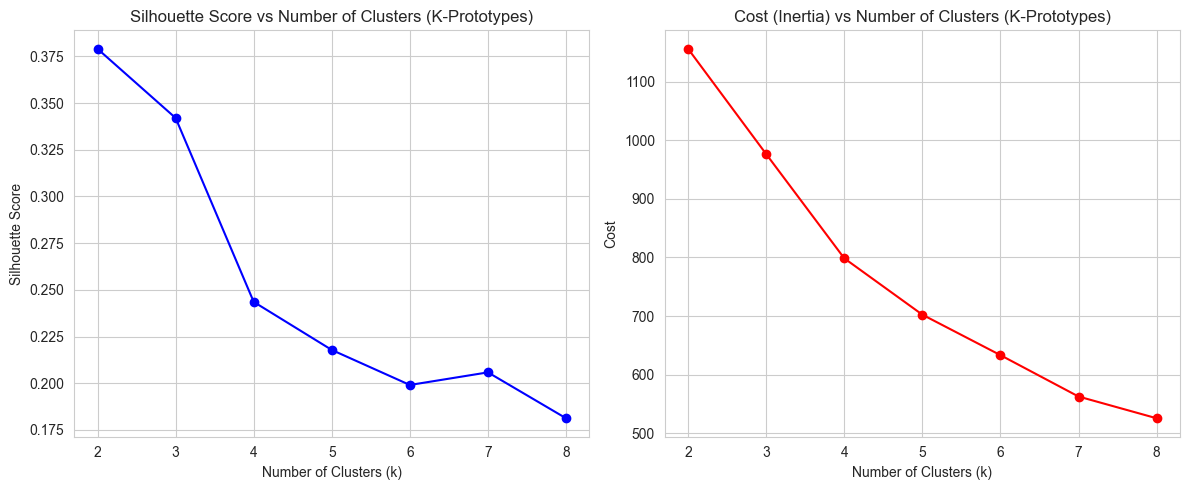

In [147]:
# === Plot Results ===
plt.figure(figsize=(12, 5))

# Silhouette plot
plt.subplot(1, 2, 1)
plt.plot(k_range, silhouette_scores, marker='o', color='blue')
plt.title('Silhouette Score vs Number of Clusters (K-Prototypes)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_range)
plt.grid(True)

# Cost plot
plt.subplot(1, 2, 2)
plt.plot(k_range, costs, marker='o', color='red')
plt.title('Cost (Inertia) vs Number of Clusters (K-Prototypes)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost')
plt.xticks(k_range)
plt.grid(True)

plt.tight_layout()
plt.show()

### Grid Search

In [148]:

param_grid = {
    'n_clusters': range(2, 9),  # Number of clusters to test
    'init': ['Huang', 'Cao'],   # Initialization methods
    'n_init': [5, 10]          # Number of initializations
}

# Create a list of parameter combinations
grid = ParameterGrid(param_grid)

best_score = -1
best_params = None
results = []

print("Starting Grid Search for K-Prototypes...")
print("-" * 30)

# Prepare the data (Include data prep from the previous successful cell)
numerical_cols = province_df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = province_df.select_dtypes(include='object').columns.tolist()

# Separate numerical and categorical data
X_numerical = province_df[numerical_cols].values
X_categorical = province_df[categorical_cols].values

# Combine the data for K-Prototypes. K-Prototypes expects categorical features last.
X = np.concatenate((X_numerical, X_categorical), axis=1)

# Get the indices of categorical columns in the combined matrix
# They will be after all numerical columns
categorical_indices_combined = list(range(X_numerical.shape[1], X.shape[1]))

# Compute Gower distance matrix (if using precomputed metric for silhouette)
# Make sure 'gower_dist' is computed before the loop if metric='precomputed'
X_for_gower = province_df.drop(columns=['cluster'], errors='ignore').copy() # Re-create if needed
print("Computing Gower distance matrix (one-time, may take a moment)...")
gower_dist = gower.gower_matrix(X_for_gower) # Compute if needed
print("Gower distance computed!")


for params in grid:
    n_clusters = params['n_clusters']
    init_method = params['init']
    n_init = params['n_init']

    print(f"Testing params: k={n_clusters}, init='{init_method}', n_init={n_init}")

    try:
        # Initialize and train K-Prototypes model
        kp = KPrototypes(
            n_clusters=n_clusters,
            init=init_method,
            n_init=n_init,
            verbose=0, # Set verbose to 0 for cleaner grid search output
            random_state=42
        )
        clusters = kp.fit_predict(X, categorical=categorical_indices_combined)
        score = silhouette_score(gower_dist, clusters, metric='precomputed')


        results.append({
            'n_clusters': n_clusters,
            'init': init_method,
            'n_init': n_init,
            'silhouette_score': score,
            'cost': kp.cost_
        })

        print(f"  Silhouette Score: {score:.4f}, Cost: {kp.cost_:.2f}")

        # Check for best score
        if score > best_score:
            best_score = score
            best_params = params

    except Exception as e:
        print(f"  Error with params {params}: {e}")
        results.append({
            'n_clusters': n_clusters,
            'init': init_method,
            'n_init': n_init,
            'silhouette_score': None,
            'cost': None,
            'error': str(e)
        })


print("-" * 30)
print("\nGrid Search Complete.")
print(f"Best Silhouette Score: {best_score:.4f}")
print(f"Best Parameters: {best_params}")

# Optional: Convert results to DataFrame for easier viewing
results_df = pd.DataFrame(results)
display(results_df.sort_values(by='silhouette_score', ascending=False))

# Restore warnings
warnings.filterwarnings("default", category=DeprecationWarning)
warnings.filterwarnings("default", category=UserWarning)

Starting Grid Search for K-Prototypes...
------------------------------
Computing Gower distance matrix (one-time, may take a moment)...
Gower distance computed!
Testing params: k=2, init='Huang', n_init=5
  Silhouette Score: 0.3791, Cost: 1156.07
Testing params: k=2, init='Huang', n_init=10
  Silhouette Score: 0.3791, Cost: 1156.07
Testing params: k=2, init='Huang', n_init=10
  Silhouette Score: 0.3791, Cost: 1156.07
Testing params: k=3, init='Huang', n_init=5
  Silhouette Score: 0.3791, Cost: 1156.07
Testing params: k=3, init='Huang', n_init=5
  Silhouette Score: 0.3420, Cost: 976.41
Testing params: k=3, init='Huang', n_init=10
  Silhouette Score: 0.3420, Cost: 976.41
Testing params: k=3, init='Huang', n_init=10
  Silhouette Score: 0.3420, Cost: 976.41
Testing params: k=4, init='Huang', n_init=5
  Silhouette Score: 0.3420, Cost: 976.41
Testing params: k=4, init='Huang', n_init=5
  Silhouette Score: 0.2397, Cost: 806.23
Testing params: k=4, init='Huang', n_init=10
  Silhouette Score: 

,n_clusters,init,n_init,silhouette_score,cost
0,2,Huang,5,0.379056,1156.070375
1,2,Huang,10,0.379056,1156.070375
15,2,Cao,10,0.379056,1156.070375
14,2,Cao,5,0.363665,1156.210411
16,3,Cao,5,0.342759,958.320964
17,3,Cao,10,0.342759,958.320964
2,3,Huang,5,0.342019,976.408486
3,3,Huang,10,0.342019,976.408486
5,4,Huang,10,0.243542,798.522807
19,4,Cao,10,0.243542,798.522807


### Optuna Bayesian / Smart Search

In [149]:
import warnings
warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning,
    message=".*datetime.datetime.utcnow.*"
)


In [150]:
numerical_cols = province_df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = province_df.select_dtypes(include='object').columns.tolist()

X_numerical = province_df[numerical_cols].values
X_categorical = province_df[categorical_cols].values

X = np.concatenate((X_numerical, X_categorical), axis=1)
categorical_indices_combined = list(range(X_numerical.shape[1], X.shape[1]))

# Compute Gower distance once for silhouette
print("Computing Gower distance matrix (one-time, may take a moment)...")
X_for_gower = province_df.drop(columns=['cluster'], errors='ignore').copy()
gower_dist = gower.gower_matrix(X_for_gower)
print("Gower distance computed!")

def objective(trial):
    # n_clusters = trial.suggest_int("n_clusters", 2, 10)  # cluster range
    n_clusters = 3
    init_method = trial.suggest_categorical("init", ["Huang", "Cao"])
    n_init = trial.suggest_int("n_init", 5, 15)
    gamma = trial.suggest_float("gamma", 0.1, 5.0)  # categorical weight

    try:
        model = KPrototypes(
            n_clusters=n_clusters,
            init=init_method,
            n_init=n_init,
            gamma=gamma,
            verbose=0,
            random_state=42
        )
        clusters = model.fit_predict(X, categorical=categorical_indices_combined)

        # Use silhouette with precomputed Gower distance
        score = silhouette_score(gower_dist, clusters, metric="precomputed")
        return score

    except Exception as e:
        # Failures return very low score
        return -1.0

# Optuna Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)  # try 50 trials


print("\n📊 Optuna Search Complete!")
print("Best Silhouette Score:", study.best_value)
print("Best Parameters:", study.best_trial.params)

optuna_results = study.trials_dataframe(attrs=("number", "value", "params", "state"))
optuna_results = optuna_results.sort_values(by="value", ascending=False)
display(optuna_results.head(20))


[I 2025-11-15 12:58:00,128] A new study created in memory with name: no-name-0dbb0c02-7d24-46c0-9c80-c79195ebf78d


Computing Gower distance matrix (one-time, may take a moment)...
Gower distance computed!


[I 2025-11-15 12:58:00,614] Trial 0 finished with value: 0.33555954694747925 and parameters: {'init': 'Cao', 'n_init': 9, 'gamma': 1.9432594012228956}. Best is trial 0 with value: 0.33555954694747925.
[I 2025-11-15 12:58:00,997] Trial 1 finished with value: 0.33555954694747925 and parameters: {'init': 'Cao', 'n_init': 11, 'gamma': 4.707642489185457}. Best is trial 0 with value: 0.33555954694747925.
[I 2025-11-15 12:58:00,997] Trial 1 finished with value: 0.33555954694747925 and parameters: {'init': 'Cao', 'n_init': 11, 'gamma': 4.707642489185457}. Best is trial 0 with value: 0.33555954694747925.
[I 2025-11-15 12:58:01,327] Trial 2 finished with value: 0.33555954694747925 and parameters: {'init': 'Cao', 'n_init': 9, 'gamma': 4.165723336243883}. Best is trial 0 with value: 0.33555954694747925.
[I 2025-11-15 12:58:01,327] Trial 2 finished with value: 0.33555954694747925 and parameters: {'init': 'Cao', 'n_init': 9, 'gamma': 4.165723336243883}. Best is trial 0 with value: 0.3355595469474792


📊 Optuna Search Complete!
Best Silhouette Score: 0.34275931119918823
Best Parameters: {'init': 'Huang', 'n_init': 14, 'gamma': 1.1957599121279923}


,number,value,params_gamma,params_init,params_n_init,state
16,16,0.342759,1.022494,Huang,15,COMPLETE
15,15,0.342759,1.195760,Huang,14,COMPLETE
35,35,0.342759,0.901486,Huang,15,COMPLETE
36,36,0.342759,0.517885,Cao,10,COMPLETE
41,41,0.342759,0.658398,Huang,15,COMPLETE
49,49,0.342759,1.357224,Cao,15,COMPLETE
45,45,0.342759,0.403254,Cao,9,COMPLETE
44,44,0.342759,0.285721,Huang,15,COMPLETE
43,43,0.342759,0.706004,Huang,15,COMPLETE
42,42,0.342759,0.869667,Huang,14,COMPLETE


### Training the model kprototypes

In [151]:
province_df.head()

,region_,person_sum,dead_sum,injured_ill_sum,missing_sum,totally_sum,partially_sum,cost_sum,has_food_sum,has_cash_sum,has_hygiene_health_sum,has_sleeping_essentials_sum,has_shelter_support_sum,num_typhoons,recurrence_rate,cost_per_family
0,CAR,-0.054337,-0.289328,1.468533,-0.366582,-0.315198,-0.341802,-0.318836,1.101987,2.480886,0.669296,0.100108,0.547383,1.543506,2.225923,-0.142834
1,13,-0.681115,-0.383372,-0.366116,-0.366582,-0.318257,-0.354367,-0.659669,-0.700387,-0.433088,-0.556704,-0.503623,-0.414833,-1.595708,-0.965762,-0.028901
2,CARAGA,-0.505180,-0.383372,-0.366116,-0.366582,-0.155792,-0.220967,-0.428785,-0.670840,-0.433088,-0.556704,-0.503623,-0.414833,-1.014372,-1.469712,-0.085301
3,CARAGA,-0.473626,-0.383372,-0.366116,-0.366582,-0.309023,-0.344380,-0.584605,-0.611746,-0.433088,-0.556704,-0.503623,-0.414833,-1.246906,-1.595699,-0.149451
4,6,-0.080856,-0.007197,-0.334209,0.019709,-0.303019,-0.218688,0.111700,0.806516,1.784066,-0.403454,-0.050824,-0.414833,0.729636,1.050039,-0.097179


In [152]:
best_params = study.best_trial.params
print("Best Params:", best_params)

numerical_cols = province_df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = province_df.select_dtypes(include="object").columns.tolist()

X_numerical = province_df[numerical_cols].values
X_categorical = province_df[categorical_cols].values

X = np.concatenate((X_numerical, X_categorical), axis=1)

categorical_indices = list(range(X_numerical.shape[1], X.shape[1]))

kproto_final = KPrototypes(
    n_clusters=3,
    init=best_params.get("init", "Cao"),
    n_init=best_params.get("n_init", 15),
    gamma=best_params.get("gamma", 4.240915318368915),
    random_state=42,
    verbose=1
)

clusters = kproto_final.fit_predict(X, categorical=categorical_indices)

final_df["cluster"] = clusters
province_df.head()


Best Params: {'init': 'Huang', 'n_init': 14, 'gamma': 1.1957599121279923}
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 6, ncost: 1065.605899047774
Run: 1, iteration: 2/100, moves: 3, ncost: 1049.0964742140259
Run: 1, iteration: 3/100, moves: 0, ncost: 1049.0964742140259
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 12, ncost: 1093.184193289792
Run: 2, iteration: 2/100, moves: 1, ncost: 1090.5761625321986
Run: 2, iteration: 3/100, moves: 2, ncost: 1087.2986918124193
Run: 2, iteration: 4/100, moves: 0, ncost: 1087.2986918124193
Init: initializing centroids
Init: initializing clusters
Run: 2, iteration: 1/100, moves: 12, ncost: 1093.184193289792
Run: 2, iteration: 2/100, moves: 1, ncost: 1090.5761625321986
Run: 2, iteration: 3/100, moves: 2, ncost: 1087.2986918124193
Run: 2, iteration: 4/100, moves: 0, ncost: 1087.2986918124193
Init: initializing centroids

,region_,person_sum,dead_sum,injured_ill_sum,missing_sum,totally_sum,partially_sum,cost_sum,has_food_sum,has_cash_sum,has_hygiene_health_sum,has_sleeping_essentials_sum,has_shelter_support_sum,num_typhoons,recurrence_rate,cost_per_family
0,CAR,-0.054337,-0.289328,1.468533,-0.366582,-0.315198,-0.341802,-0.318836,1.101987,2.480886,0.669296,0.100108,0.547383,1.543506,2.225923,-0.142834
1,13,-0.681115,-0.383372,-0.366116,-0.366582,-0.318257,-0.354367,-0.659669,-0.700387,-0.433088,-0.556704,-0.503623,-0.414833,-1.595708,-0.965762,-0.028901
2,CARAGA,-0.505180,-0.383372,-0.366116,-0.366582,-0.155792,-0.220967,-0.428785,-0.670840,-0.433088,-0.556704,-0.503623,-0.414833,-1.014372,-1.469712,-0.085301
3,CARAGA,-0.473626,-0.383372,-0.366116,-0.366582,-0.309023,-0.344380,-0.584605,-0.611746,-0.433088,-0.556704,-0.503623,-0.414833,-1.246906,-1.595699,-0.149451
4,6,-0.080856,-0.007197,-0.334209,0.019709,-0.303019,-0.218688,0.111700,0.806516,1.784066,-0.403454,-0.050824,-0.414833,0.729636,1.050039,-0.097179


In [153]:
final_df['cluster'].value_counts()

cluster
0    74
1    17
2     7
Name: count, dtype: int64

In [154]:
province_df_kmeans = province_df.copy()

# Separate numerical + categorical (same as in KPrototypes)
numerical_cols = province_df_kmeans.select_dtypes(include=np.number).columns.tolist()
categorical_cols = province_df_kmeans.select_dtypes(include="object").columns.tolist()

X_num = province_df_kmeans[numerical_cols].values
region = province_df_kmeans[categorical_cols].values  # assumes "Region" is in object dtype


# One-Hot Encoding + KMeans
ohe = OneHotEncoder(sparse_output=False, drop='first')
region_ohe = ohe.fit_transform(region)

# Combine numerical + one-hot encoded categorical
X_ohe = np.hstack([X_num, region_ohe])

# Train KMeans (clusters = 3 to match KPrototypes)
kmeans_ohe = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_ohe_labels = kmeans_ohe.fit_predict(X_ohe)

# Evaluate silhouette
silhouette_ohe = silhouette_score(X_ohe, kmeans_ohe_labels)
province_df_kmeans["kmeans_ohe_cluster"] = kmeans_ohe_labels
print(f"KMeans (One-Hot Encoded Region) Silhouette Score: {silhouette_ohe:.3f}")


# Label Encoding + KMeans
le = LabelEncoder()
region_le = le.fit_transform(region.ravel()).reshape(-1, 1)

# Combine numerical + label encoded categorical
X_le = np.hstack([X_num, region_le])

# Train KMeans
kmeans_le = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_le_labels = kmeans_le.fit_predict(X_le)


# Evaluate silhouette
silhouette_le = silhouette_score(X_le, kmeans_le_labels)
province_df_kmeans["kmeans_le_cluster"] = kmeans_le_labels
print(f"KMeans (Label Encoded Region) Silhouette Score: {silhouette_le:.3f}")

KMeans (One-Hot Encoded Region) Silhouette Score: 0.398
KMeans (Label Encoded Region) Silhouette Score: 0.359

KMeans (Label Encoded Region) Silhouette Score: 0.359


DEMONSTRATING K-PROTOTYPES ADVANTAGE FOR MIXED DATA

FEATURE SPACE DIMENSIONALITY COMPARISON

DEMONSTRATING K-PROTOTYPES ADVANTAGE FOR MIXED DATA

FEATURE SPACE DIMENSIONALITY COMPARISON

           Method Original Features  Feature Space Dimensions    Dimensionality Impact
     K-Prototypes    15 num + 1 cat                        16    Native mixed handling
  K-Means (Label)    15 num + 1 cat                        16    Artificial ordinality
K-Means (One-Hot)    15 num + 1 cat                        32  Curse of dimensionality

One-Hot Encoding increased dimensions by 100.0%

           Method Original Features  Feature Space Dimensions    Dimensionality Impact
     K-Prototypes    15 num + 1 cat                        16    Native mixed handling
  K-Means (Label)    15 num + 1 cat                        16    Artificial ordinality
K-Means (One-Hot)    15 num + 1 cat                        32  Curse of dimensionality

One-Hot Encoding increased dimensions by 100.0%


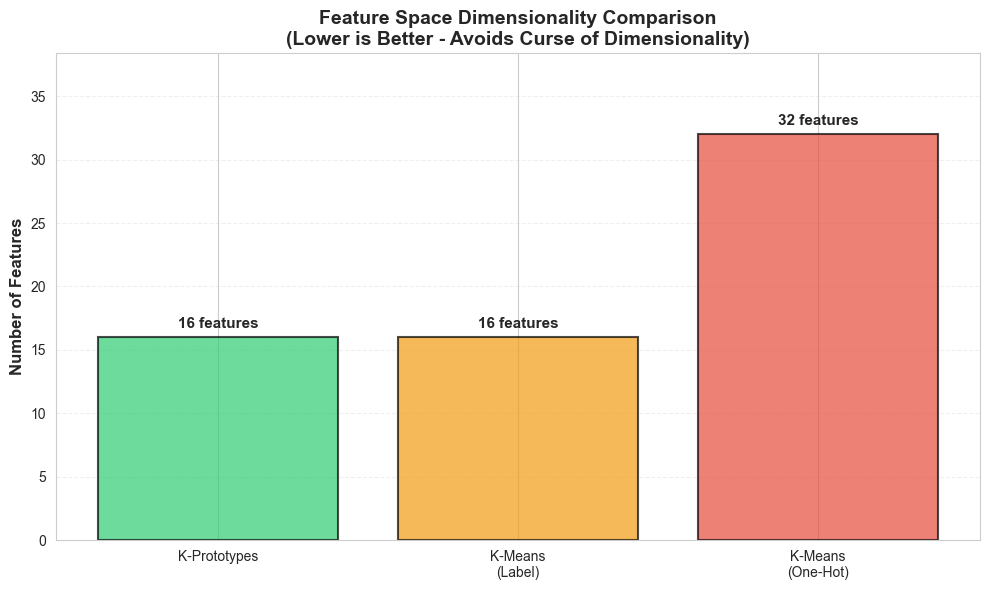

In [155]:
province_df_kmeans = province_df.copy()

# Separate numerical + categorical (same as in KPrototypes)
numerical_cols = province_df_kmeans.select_dtypes(include=np.number).columns.tolist()
categorical_cols = province_df_kmeans.select_dtypes(include="object").columns.tolist()

X_num = province_df_kmeans[numerical_cols].values
region = province_df_kmeans[categorical_cols].values  # assumes "Region" is in object dtype

print("="*80)
print("DEMONSTRATING K-PROTOTYPES ADVANTAGE FOR MIXED DATA")
print("="*80)

# FEATURE SPACE DIMENSIONALITY COMPARISON
print("\n" + "="*80)
print("FEATURE SPACE DIMENSIONALITY COMPARISON")
print("="*80)

# One-Hot Encoding
ohe = OneHotEncoder(sparse_output=False, drop='first')
region_ohe = ohe.fit_transform(region)
X_ohe = np.hstack([X_num, region_ohe])

# Label Encoding
le = LabelEncoder()
region_le = le.fit_transform(region.ravel()).reshape(-1, 1)
X_le = np.hstack([X_num, region_le])

# Display dimensionality
dim_comparison = pd.DataFrame({
    'Method': ['K-Prototypes', 'K-Means (Label)', 'K-Means (One-Hot)'],
    'Original Features': [f"{len(numerical_cols)} num + {len(categorical_cols)} cat", 
                          f"{len(numerical_cols)} num + {len(categorical_cols)} cat",
                          f"{len(numerical_cols)} num + {len(categorical_cols)} cat"],
    'Feature Space Dimensions': [len(numerical_cols) + len(categorical_cols), 
                                  X_le.shape[1], 
                                  X_ohe.shape[1]],
    'Dimensionality Impact': ['Native mixed handling', 
                              ' Artificial ordinality', 
                              ' Curse of dimensionality']
})

print("\n" + dim_comparison.to_string(index=False))
print(f"\nOne-Hot Encoding increased dimensions by {((X_ohe.shape[1] / (len(numerical_cols) + len(categorical_cols))) - 1) * 100:.1f}%")

# Visualize dimensionality
fig, ax = plt.subplots(figsize=(10, 6))
methods = ['K-Prototypes', 'K-Means\n(Label)', 'K-Means\n(One-Hot)']
dimensions = [len(numerical_cols) + len(categorical_cols), X_le.shape[1], X_ohe.shape[1]]
colors = ['#2ecc71', '#f39c12', '#e74c3c']

bars = ax.bar(methods, dimensions, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Number of Features', fontsize=12, fontweight='bold')
ax.set_title('Feature Space Dimensionality Comparison\n(Lower is Better - Avoids Curse of Dimensionality)', 
             fontsize=14, fontweight='bold')
ax.set_ylim(0, max(dimensions) * 1.2)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bar, dim in zip(bars, dimensions):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{dim} features',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


In [156]:
# ==========================================
# 📊 3D PCA Visualization:
#    K-Prototypes vs KMeans (One-Hot & Label Encoded)
# ==========================================
from sklearn.decomposition import PCA
import plotly.express as px

# ✅ More distinct colors for K-Prototypes
color_map_kproto = {
    0: '#0052CC',  # royal blue
    1: '#2ECC71',  # emerald green
    2: '#E74C3C',  # crimson red
    3: '#9B59B6',  # purple
    4: '#F1C40F',  # gold
}

# Original color map for KMeans (can stay simpler)
color_map_kmeans = {
    0: '#1f77b4',
    1: '#ff7f0e',
    2: '#2ca02c',
    3: '#d62728',
    4: '#9467bd',
}

# K-PROTOTYPES CLUSTERS  (main model)
X_kproto = province_df[numerical_cols].copy()
clusters_kproto = final_df['cluster'].values

pca_kproto = PCA(n_components=3)
X_kproto_pca = pca_kproto.fit_transform(X_kproto)

df_kproto_vis = pd.DataFrame(X_kproto_pca, columns=['PC1', 'PC2', 'PC3'])
df_kproto_vis['Cluster'] = clusters_kproto

fig_kproto = px.scatter_3d(
    df_kproto_vis,
    x='PC1', y='PC2', z='PC3',
    color='Cluster',
    title=f'K-Prototypes Clusters (Explained Var: {pca_kproto.explained_variance_ratio_[:3].sum()*100:.1f}%)',
    color_discrete_map=color_map_kproto
)
fig_kproto.update_traces(marker=dict(size=6, line=dict(width=1, color='DarkSlateGrey')))
fig_kproto.update_layout(height=600)
fig_kproto.show()

# KMEANS - ONE HOT ENCODED
pca_ohe = PCA(n_components=3)
X_ohe_pca = pca_ohe.fit_transform(X_ohe)

df_ohe_vis = pd.DataFrame(X_ohe_pca, columns=['PC1', 'PC2', 'PC3'])
df_ohe_vis['Cluster'] = kmeans_ohe_labels

fig_ohe = px.scatter_3d(
    df_ohe_vis,
    x='PC1', y='PC2', z='PC3',
    color='Cluster',
    title=f'KMeans (One-Hot Encoded) (Explained Var: {pca_ohe.explained_variance_ratio_[:3].sum()*100:.1f}%)',
    color_discrete_map=color_map_kmeans
)
fig_ohe.update_traces(marker=dict(size=6, line=dict(width=1, color='DarkSlateGrey')))
fig_ohe.update_layout(height=600)
fig_ohe.show()

# KMEANS - LABEL ENCODED
pca_le = PCA(n_components=3)
X_le_pca = pca_le.fit_transform(X_le)

df_le_vis = pd.DataFrame(X_le_pca, columns=['PC1', 'PC2', 'PC3'])
df_le_vis['Cluster'] = kmeans_le_labels

fig_le = px.scatter_3d(
    df_le_vis,
    x='PC1', y='PC2', z='PC3',
    color='Cluster',
    title=f'KMeans (Label Encoded) (Explained Var: {pca_le.explained_variance_ratio_[:3].sum()*100:.1f}%)',
    color_discrete_map=color_map_kmeans
)
fig_le.update_traces(marker=dict(size=6, line=dict(width=1, color='DarkSlateGrey')))
fig_le.update_layout(height=600)
fig_le.show()


In [157]:
from scipy.spatial.distance import pdist
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
import numpy as np
import pandas as pd
import gower

# --- Helper function ---
def pairwise_stats(distances):
    """Compute mean, std, and std/mean ratio for given pairwise distance array."""
    mean = distances.mean()
    std = distances.std()
    ratio = std / mean
    return mean, std, ratio

# --- Define numeric + categorical columns ---
numerical_cols = province_df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = ['region_']  # adjust to match your data

# Scale numeric features ---
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(province_df[numerical_cols])

# Label Encode categorical for Label Encoded (KMeans) ---
le = LabelEncoder()
X_cat_le = le.fit_transform(province_df[categorical_cols[0]]).reshape(-1, 1)

# One-Hot Encode categorical for KMeans (OHE) ---
ohe = OneHotEncoder(sparse_output=False, drop='first')
X_cat_ohe = ohe.fit_transform(province_df[categorical_cols])

# Combine ---
X_le = np.hstack([X_num_scaled, X_cat_le])   # for KMeans Label Encoded
X_ohe = np.hstack([X_num_scaled, X_cat_ohe]) # for KMeans One-Hot

# K-Prototypes-style dissimilarities using Gower distance ---
#    Gower handles mixed numeric + categorical data correctly
X_kproto_like = province_df[numerical_cols + categorical_cols]
gower_distances = gower.gower_matrix(X_kproto_like)
gower_flat = gower_distances[np.triu_indices_from(gower_distances, k=1)]

# Pairwise distances ---
mean_kproto, std_kproto, ratio_kproto = pairwise_stats(gower_flat)
mean_le, std_le, ratio_le = pairwise_stats(pdist(X_le, metric='euclidean'))
mean_ohe, std_ohe, ratio_ohe = pairwise_stats(pdist(X_ohe, metric='euclidean'))

# Display results ---
print("\n======================================================================")
print("Pairwise Distance Concentration Analysis (Scaled Numeric Features)")
print("======================================================================")
print(f"{'Method':<30}{'Mean Dist':>15}{'Std':>15}{'Std/Mean Ratio':>20}")
print("-"*80)
print(f"{'K-Prototypes (Gower)':<30}{mean_kproto:>15.4f}{std_kproto:>15.4f}{ratio_kproto:>20.4f}")
print(f"{'K-Means (Label Encoded)':<30}{mean_le:>15.4f}{std_le:>15.4f}{ratio_le:>20.4f}")
print(f"{'K-Means (One-Hot Encoded)':<30}{mean_ohe:>15.4f}{std_ohe:>15.4f}{ratio_ohe:>20.4f}")
print("======================================================================")
print("🔹 Lower Std/Mean ratio means distances are more concentrated (curse of dimensionality).")
print("🔹 Gower shows mixed-type dissimilarities for K-Prototypes-style analysis.")



Pairwise Distance Concentration Analysis (Scaled Numeric Features)
Method                              Mean Dist            Std      Std/Mean Ratio
--------------------------------------------------------------------------------
K-Prototypes (Gower)                   0.1864         0.0913              0.4897
K-Means (Label Encoded)                7.9757         3.8899              0.4877
K-Means (One-Hot Encoded)              4.7881         3.0305              0.6329
🔹 Lower Std/Mean ratio means distances are more concentrated (curse of dimensionality).
🔹 Gower shows mixed-type dissimilarities for K-Prototypes-style analysis.


#### Showing the values

In [158]:
# Filter the DataFrame to show only cluster 2
cluster_2_df = final_df[final_df['cluster'] == 2]

# Display the filtered DataFrame
# display(cluster_2_df)

## Evaluation

In [159]:
# ========================================
# 4. COMPUTE METRICS FOR ALL METHODS - CORRECTED VERSION
# ========================================
print("\n" + "=" * 50)
print("COMPUTING EVALUATION METRICS (CORRECTED)")
print("=" * 50)
print("⚠️ IMPORTANT: Using appropriate distance metrics for each method")

# Compute Gower distance matrix (for mixed-type data evaluation)
print("\nComputing Gower distance matrix for K-Prototypes evaluation...")
X_gower = X_base.copy()
for col in categorical_cols_comp:
    X_gower[col] = X_gower[col].astype(str)

gower_dist_comp = gower.gower_matrix(X_gower)
print("Gower distance matrix computed!")

# Initialize results dictionary
metrics_results = {
    'Method': [],
    'Silhouette': [],
    'Davies-Bouldin': [],
    'Dunn': [],
    'McClain': []
}

# === EVALUATE K-PROTOTYPES (Using Gower distance) ===
print("\nEvaluating K-Prototypes (using Gower distance)...")
sil_kproto = silhouette_score(gower_dist_comp, clusters_kproto, metric='precomputed')
dbi_kproto = davies_bouldin_score(X_numerical, clusters_kproto)
dunn_kproto = dunn(gower_dist_comp, clusters_kproto)
mcclain_kproto = mcclain_index(gower_dist_comp, clusters_kproto)

metrics_results['Method'].append('K-Prototypes')
metrics_results['Silhouette'].append(sil_kproto)
metrics_results['Davies-Bouldin'].append(dbi_kproto)
metrics_results['Dunn'].append(dunn_kproto)
metrics_results['McClain'].append(mcclain_kproto)

print(f"  Silhouette: {sil_kproto:.4f}")
print(f"  Davies-Bouldin: {dbi_kproto:.4f}")
print(f"  Dunn: {dunn_kproto:.4f}")
print(f"  McClain: {mcclain_kproto:.4f}")

# === EVALUATE K-MEANS ONE-HOT (Using Euclidean distance on OHE feature space) ===
print("\nEvaluating K-Means (One-Hot) using its actual feature space...")

# Compute distance matrix for OHE feature space
from scipy.spatial.distance import pdist, squareform
ohe_dist_matrix = squareform(pdist(X_kmeans_ohe, metric='euclidean'))

sil_ohe = silhouette_score(X_kmeans_ohe, clusters_kmeans_ohe)  # Standard silhouette
dbi_ohe = davies_bouldin_score(X_kmeans_ohe, clusters_kmeans_ohe)
dunn_ohe = dunn(ohe_dist_matrix, clusters_kmeans_ohe)
mcclain_ohe = mcclain_index(ohe_dist_matrix, clusters_kmeans_ohe)

metrics_results['Method'].append('K-Means (One-Hot)')
metrics_results['Silhouette'].append(sil_ohe)
metrics_results['Davies-Bouldin'].append(dbi_ohe)
metrics_results['Dunn'].append(dunn_ohe)
metrics_results['McClain'].append(mcclain_ohe)

print(f"  Silhouette: {sil_ohe:.4f}")
print(f"  Davies-Bouldin: {dbi_ohe:.4f}")
print(f"  Dunn: {dunn_ohe:.4f}")
print(f"  McClain: {mcclain_ohe:.4f}")

# === EVALUATE K-MEANS LABEL ENCODED (Using Euclidean distance on LE feature space) ===
print("\nEvaluating K-Means (Label Encoding) using its actual feature space...")

# Compute distance matrix for LE feature space
le_dist_matrix = squareform(pdist(X_kmeans_le, metric='euclidean'))

sil_le = silhouette_score(X_kmeans_le, clusters_kmeans_le)  # Standard silhouette
dbi_le = davies_bouldin_score(X_kmeans_le, clusters_kmeans_le)
dunn_le = dunn(le_dist_matrix, clusters_kmeans_le)
mcclain_le = mcclain_index(le_dist_matrix, clusters_kmeans_le)

metrics_results['Method'].append('K-Means (Label Enc.)')
metrics_results['Silhouette'].append(sil_le)
metrics_results['Davies-Bouldin'].append(dbi_le)
metrics_results['Dunn'].append(dunn_le)
metrics_results['McClain'].append(mcclain_le)

print(f"  Silhouette: {sil_le:.4f}")
print(f"  Davies-Bouldin: {dbi_le:.4f}")
print(f"  Dunn: {dunn_le:.4f}")
print(f"  McClain: {mcclain_le:.4f}")

print("\n✅ All metrics computed using appropriate distance measures for each method!")
print("\n💡 KEY POINTS:")
print("• K-Prototypes: Evaluated using Gower distance (appropriate for mixed-type data)")
print("• K-Means (One-Hot): Evaluated using Euclidean distance on one-hot encoded features")
print("• K-Means (Label Enc.): Evaluated using Euclidean distance on label encoded features")
print("• This ensures fair comparison as each method is evaluated in its natural space")



COMPUTING EVALUATION METRICS (CORRECTED)
⚠️ IMPORTANT: Using appropriate distance metrics for each method

Computing Gower distance matrix for K-Prototypes evaluation...
Gower distance matrix computed!

Evaluating K-Prototypes (using Gower distance)...
  Silhouette: 0.3428
  Davies-Bouldin: 1.4725
  Dunn: 0.1268
  McClain: 0.5130

Evaluating K-Means (One-Hot) using its actual feature space...
  Silhouette: 0.7130
  Davies-Bouldin: 0.4416
  Dunn: 0.0671
  McClain: 0.1645

Evaluating K-Means (Label Encoding) using its actual feature space...
  Silhouette: 0.7130
  Davies-Bouldin: 0.4416
  Dunn: 0.0671
  McClain: 0.1645

✅ All metrics computed using appropriate distance measures for each method!

💡 KEY POINTS:
• K-Prototypes: Evaluated using Gower distance (appropriate for mixed-type data)
• K-Means (One-Hot): Evaluated using Euclidean distance on one-hot encoded features
• K-Means (Label Enc.): Evaluated using Euclidean distance on label encoded features
• This ensures fair comparison a

### Clustering Methods Comparison: Evaluation Metrics

In [160]:
# ==========================================
# CLUSTERING METHODS COMPARISON:
# K-Prototypes vs K-Means (One-Hot & Label Encoded)
# ==========================================
import pandas as pd
import numpy as np
import gower
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.cluster import KMeans
from validclust import dunn

print("=" * 80)
print("CLUSTERING METHODS EVALUATION METRICS COMPARISON")
print("=" * 80)

# --- Helper function for McClain Index ---
def mcclain_index(distance_matrix, labels):
    """
    McClain Index = (avg intra-cluster distance) / (avg inter-cluster distance)
    Lower is better.
    """
    labels = np.array(labels)
    n = len(labels)

    intra_dists = []
    inter_dists = []

    for i in range(n):
        for j in range(i + 1, n):
            if labels[i] == labels[j]:
                intra_dists.append(distance_matrix[i, j])
            else:
                inter_dists.append(distance_matrix[i, j])

    intra_mean = np.mean(intra_dists) if intra_dists else 0
    inter_mean = np.mean(inter_dists) if inter_dists else 1  # avoid div0
    return intra_mean / inter_mean


CLUSTERING METHODS EVALUATION METRICS COMPARISON


In [161]:
# ========================================
# 1. PREPARE DATA FOR ALL THREE METHODS
# ========================================

# Get numerical and categorical columns
numerical_cols_comp = final_df.select_dtypes(include=np.number).columns.tolist()
if 'cluster' in numerical_cols_comp:
    numerical_cols_comp.remove('cluster')

categorical_cols_comp = ['region_']

print(f"Numerical features: {len(numerical_cols_comp)}")
print(f"Categorical features: {len(categorical_cols_comp)}")

# Prepare base data (without cluster column)
X_base = final_df.drop(columns=['cluster'], errors='ignore')

# === K-PROTOTYPES DATA (already have clusters) ===
clusters_kproto = final_df['cluster'].values
print(f"\nK-Prototypes clusters shape: {clusters_kproto.shape}")


Numerical features: 15
Categorical features: 1

K-Prototypes clusters shape: (98,)


In [162]:
# ========================================
# 2. K-MEANS WITH ONE-HOT ENCODING
# ========================================
print("\n" + "=" * 40)
print("APPLYING K-MEANS WITH ONE-HOT ENCODING")
print("=" * 40)

# Prepare data
X_numerical = X_base[numerical_cols_comp].values
X_categorical = X_base[categorical_cols_comp].values

# One-Hot Encode categorical features
ohe = OneHotEncoder(sparse_output=False, drop='first')
X_cat_ohe = ohe.fit_transform(X_categorical)

# Combine numerical + one-hot encoded
X_kmeans_ohe = np.hstack([X_numerical, X_cat_ohe])

print(f"Original features: {len(numerical_cols_comp)} numerical + {len(categorical_cols_comp)} categorical")
print(f"One-Hot encoded features: {X_kmeans_ohe.shape[1]}")

# Apply K-Means with 3 clusters (same as K-Prototypes)
kmeans_ohe = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters_kmeans_ohe = kmeans_ohe.fit_predict(X_kmeans_ohe)

print(f"K-Means (OHE) cluster distribution: {np.bincount(clusters_kmeans_ohe)}")



APPLYING K-MEANS WITH ONE-HOT ENCODING
Original features: 15 numerical + 1 categorical
One-Hot encoded features: 32
K-Means (OHE) cluster distribution: [20 75  3]


In [163]:
# ========================================
# 3. K-MEANS WITH LABEL ENCODING
# ========================================
print("\n" + "=" * 40)
print("APPLYING K-MEANS WITH LABEL ENCODING")
print("=" * 40)

# Label Encode categorical features
le = LabelEncoder()
X_cat_le = le.fit_transform(X_categorical.ravel()).reshape(-1, 1)

# Combine numerical + label encoded
X_kmeans_le = np.hstack([X_numerical, X_cat_le])

print(f"Label encoded features: {X_kmeans_le.shape[1]}")

# Apply K-Means with 3 clusters
kmeans_le = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters_kmeans_le = kmeans_le.fit_predict(X_kmeans_le)

print(f"K-Means (LE) cluster distribution: {np.bincount(clusters_kmeans_le)}")



APPLYING K-MEANS WITH LABEL ENCODING
Label encoded features: 16
K-Means (LE) cluster distribution: [20 75  3]


In [164]:
# ========================================
# 5. DISPLAY RESULTS TABLE
# ========================================
print("\n" + "=" * 80)
print("CLUSTERING EVALUATION METRICS COMPARISON")
print("=" * 80)

# Create DataFrame for better display
metrics_df = pd.DataFrame(metrics_results)

# Round values for better readability
for col in ['Silhouette (Gower)', 'Davies-Bouldin', 'Dunn', 'McClain']:
    metrics_df[col] = metrics_df[col].round(4)

print(metrics_df.to_string(index=False))

print("\n" + "=" * 80)
print("METRIC INTERPRETATIONS:")
print("• Silhouette (Gower): Higher is better (range: -1 to 1)")
print("• Davies-Bouldin: Lower is better (0 to ∞)")
print("• Dunn: Higher is better (0 to ∞)")
print("• McClain: Lower is better (0 to ∞)")
print("=" * 80)



CLUSTERING EVALUATION METRICS COMPARISON


KeyError: 'Silhouette (Gower)'